# CNN実装
---

### モジュールの読み込み

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10, ImageFolder
from torchvision.utils import make_grid

# モデル構造の表示
from torchinfo import summary

# その他
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tqdm import tqdm
from PIL import Image

#チューニング
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
import os
import io

from omegaconf import DictConfig, ListConfig,OmegaConf

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_RUN_NAME,MLFLOW_USER,MLFLOW_SOURCE_NAME

### 引数設定

In [2]:
#yaml読み込み
targetDirecotory = "./"
fileName = "config_ipynb.yaml"

cfg = OmegaConf.load(os.path.join(targetDirecotory, fileName))
print(cfg.name)

ipynb


### 記録クラス

In [3]:
##-------------mlflowを使った記録するクラス関係
class MlflowWriter():
    # def __init__(self, experiment_name,tags):
    #     self.client = MlflowClient()
    #     try:
    #         self.experiment_id = self.client.create_experiment(experiment_name,tags)
    #     except Exception as e:
    #         print(e)
    #         self.experiment_id = self.client.get_experiment_by_name(experiment_name).experiment_id

    #     self.experiment = self.client.get_experiment(self.experiment_id)
    #     print("New experiment started")
    #     print(f"Name: {self.experiment.name}")
    #     print(f"Experiment_id: {self.experiment.experiment_id}")
    #     print(f"Artifact Location: {self.experiment.artifact_location}")

    def log_params_from_omegaconf_dict(self, params):
        for param_name, element in params.items():
            self._explore_recursive(param_name, element)

    def _explore_recursive(self, parent_name, element):
        if isinstance(element, DictConfig):
            for k, v in element.items():
                if isinstance(v, DictConfig) or isinstance(v, ListConfig):
                    self._explore_recursive(f'{parent_name}.{k}', v)
                else:
                    self.client.log_param(self.run_id, f'{parent_name}.{k}', v)
        elif isinstance(element, ListConfig):
            for i, v in enumerate(element):
                self.client.log_param(self.run_id, f'{parent_name}.{i}', v)
        else:
            self.client.log_param(self.run_id, f'{parent_name}', element)

    def log_param(self, key, value):
        self.client.log_param(self.run_id, key, value)

    def log_metric(self, key, value):
        self.client.log_metric(self.run_id, key, value)

    def log_metric_step(self, key, value, step):
        self.client.log_metric(self.run_id, key, value, step=step)

    def log_artifact(self, local_path):
        self.client.log_artifact(self.run_id, local_path)

    def log_dict(self, dictionary, file):
        self.client.log_dict(self.run_id, dictionary, file)
    
    def log_figure(self, figure, file):
        self.client.log_figure(self.run_id, figure, file)
        
    def set_terminated(self):
        self.client.set_terminated(self.run_id)

    def create_new_run(self, tags=None):
        self.run = self.client.create_run(self.experiment_id, tags=tags)
        self.run_id = self.run.info.run_id
        print(f"New run started: {tags['mlflow.runName']}")
    def __init__(self, experiment_name,run_tags=None, **kwargs):
        self.client = MlflowClient(**kwargs)
        try:
            self.experiment_id = self.client.create_experiment(experiment_name)
        except:
            self.experiment_id = self.client.get_experiment_by_name(experiment_name).experiment_id

        self.run_id = self.client.create_run(self.experiment_id,tags=run_tags).info.run_id

    # def log_params_from_omegaconf_dict(self, params):
    #     for param_name, element in params.items():
    #         self._explore_recursive(param_name, element)

    # def _explore_recursive(self, parent_name, element):
    #     if isinstance(element, DictConfig):
    #         for k, v in element.items():
    #             if isinstance(v, DictConfig) or isinstance(v, ListConfig):
    #                 self._explore_recursive(f'{parent_name}.{k}', v)
    #             else:
    #                 self.client.log_param(self.run_id, f'{parent_name}.{k}', v)
    #     elif isinstance(element, ListConfig):
    #         for i, v in enumerate(element):
    #             self.client.log_param(self.run_id, f'{parent_name}.{i}', v)

    def log_torch_model(self, model):
        with mlflow.start_run(self.run_id):
            mlflow.pytorch.log_model(model, 'models')

    def log_param(self, key, value):
        self.client.log_param(self.run_id, key, value)

    def log_metric(self, key, value):
        self.client.log_metric(self.run_id, key, value)

    def log_artifact(self, local_path):
        self.client.log_artifact(self.run_id, local_path)

    def set_terminated(self):
        self.client.set_terminated(self.run_id)

    



 #MLflow Tracking を使用して実験過程、結果を記録するwriterを作成
EXPERIMENT_NAME = f"{cfg.name}" #mlflow uiの「Experiments」に表示される実験名
run_tags = {'seed':cfg.seed,
    MLFLOW_RUN_NAME:cfg.name,
    MLFLOW_USER:"hideaki Omote",
    MLFLOW_SOURCE_NAME:"__file__",
    }
writer = MlflowWriter(experiment_name= EXPERIMENT_NAME,run_tags=run_tags) #writerを作成しexperiment=実験を開始
writer.log_params_from_omegaconf_dict(cfg)#cfgのハイパーパラメーターを一括でwriterで記録(mlflow ui　の Parameters)

### シード固定化

In [4]:

#クロージャを利用してseed値を固定 https://qiita.com/naomi7325/items/57d141f2e56d644bdf5f
def initialize_fix_seed_dataLoader(seed):
    def fix_seed_dataLoader(dataloader,**args):#シードを固定したDataLoader　DataLoaderの代わりに使う
        def seed_worker(worker_id):
            worker_seed = torch.initial_seed() % 2**32
            np.random.seed(worker_seed)
            random.seed(worker_seed)
        g = torch.Generator()
        g.manual_seed(seed)
        return DataLoader(dataloader,**args,worker_init_fn=seed_worker,generator=g)
    
    return fix_seed_dataLoader

#シードを固定化する関数
def fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed) #cpuとcudaも同時に固定
    #torch.cuda.manual_seed(seed) #上記で呼び出される
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


fix_seed(cfg.seed) #シード固定化
fix_seed_dataLoader = initialize_fix_seed_dataLoader(cfg.seed)#seed固定のDataLoader関数を作成　DataLoader関数の代わりに使用する
##-----------------------------------

##fix_seed_dataloader関数は以下の処理を代わりに実行する関数
'''
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker
    generator=g,
)
'''

'\ndef seed_worker(worker_id):\n    worker_seed = torch.initial_seed() % 2**32\n    np.random.seed(worker_seed)\n    random.seed(worker_seed)\n\ng = torch.Generator()\ng.manual_seed(seed)\n\nDataLoader(\n    train_dataset,\n    batch_size=batch_size,\n    num_workers=num_workers,\n    worker_init_fn=seed_worker\n    generator=g,\n)\n'

### transformを選択する関数

In [5]:
#入力は
def make_transform(pattern=None):
    

    #必ず使うtransform
    default_transform_list = [
        transforms.ToTensor(),
        transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ),
        ]
    #使用するtransform indexが番号に対応
    use_transform_list = {
        "a":transforms.RandomHorizontalFlip(p=0.5),#0:画像を水平反転
        #"b":transforms.RandomVerticalFlip(p=0.5), #1:画像を垂直反転
        "b":transforms.RandomRotation(degrees=(-10,10)), #2:画像回転
        "c":transforms.RandomCrop(32, padding=4), #3:画像を切り抜き

        #transforms.GaussianBlur(kernel_size=15),
        #transforms.RandomPosterize(bits=1, p=1.0),
        #transforms.RandomAdjustSharpness(p=1.0, sharpness_factor=3),

        "d":transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0), #4:画像の一部を塗りつぶす
    }


    #transformを作成
    if(pattern == None):#空ならデフォルト
        print("transform")
        print(pattern)
        print(default_transform_list)
        print("\n")
        return  transforms.Compose(default_transform_list)

    else:#それいがいなら加工したtransformをわたす。
        
        pattern_split = list(pattern)

        pre_transform_list = []
        suf_transform_list = []

        for value in pattern_split:
            use_transform = use_transform_list[value]
            if isinstance(use_transform,transforms.RandomErasing):
                suf_transform_list.append(use_transform)
            else:
                pre_transform_list.append(use_transform)

        transform_list = pre_transform_list + default_transform_list + suf_transform_list
        
        print("transform")
        print(pattern)
        print(transform_list)
        print("\n")
        return transforms.Compose(transform_list)

### 計算デバイス

In [6]:
# GPUが利用できる場合はGPUを選択
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 1. データの準備
---

In [7]:
def load_cifar10(transform, train:bool):
    cifar10_dataset = CIFAR10(
                        root='./data',
                        train=train,
                        download=True,
                        transform=transform
                        )
    return cifar10_dataset

In [8]:
#データ拡張
# train_transform = transforms.Compose([
#                             # transforms.RandomHorizontalFlip(p=0.5), #画像を左右反転
#                             # transforms.RandomVerticalFlip(p=0.5), #画像を垂直反転
#                             # transforms.RandomRotation(degrees=30),#画像を回転
#                             transforms.ToTensor(),
#                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                             #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0) #画像を切り抜き
# ])
train_transform = make_transform(**cfg.transform)

test_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = load_cifar10(transform=test_transform, train=True) #訓練・検証用データなのでtransformしない
test_dataset = load_cifar10(transform=test_transform, train=False)

# データ数とデータ形状を確認
print(f'data size : {len(dataset)}')
print(f'data shape : {dataset[0][0].shape}')

# 学習用(Train)と検証用(Validation)への分割数を決める
valid_ratio = 0.1                               # 検証用データの割合を指定
valid_size = int(len(dataset) * valid_ratio)    # 検証用データの数
train_size = len(dataset) - valid_size          # 学習用データ = 全体 - 検証用データ
print(f'train samples : {train_size}')
print(f'valid samples : {valid_size}')

# 読み込んだデータをランダムに選んで分割
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataset.dataset.transform = train_transform #訓練用にtransform適用






# データローダーを作成
train_loader = fix_seed_dataLoader(
    train_dataset,          # データセットを指定
    #batch_size=512,          # バッチサイズを指定
    shuffle=True,           # シャッフルの有無を指定
    drop_last=True,         # バッチサイズで割り切れないデータの使用の有無を指定
    pin_memory=True,        # 少しだけ高速化が期待できるおまじない
    num_workers=4,          # DataLoaderのプロセス数を指定
    **cfg.dataloader
)

valid_loader = fix_seed_dataLoader(
    valid_dataset,
    #batch_size=512,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    **cfg.dataloader
) 


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform
abcd
[RandomHorizontalFlip(p=0.5), RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0), RandomCrop(size=(32, 32), padding=4), ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]


Files already downloaded and verified
Files already downloaded and verified
data size : 50000
data shape : torch.Size([3, 32, 32])
train samples : 45000
valid samples : 5000


In [9]:
def sample_show(dataset):
    loader = fix_seed_dataLoader(dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=False)
    sample_cifar10, _ = next(iter(loader))
    grid = make_grid(sample_cifar10, nrow=16, padding=1, normalize=True)
    plt.figure(figsize=(12.8, 5.6))
    plt.imshow(grid.numpy().transpose(1,2,0))
    plt.show()

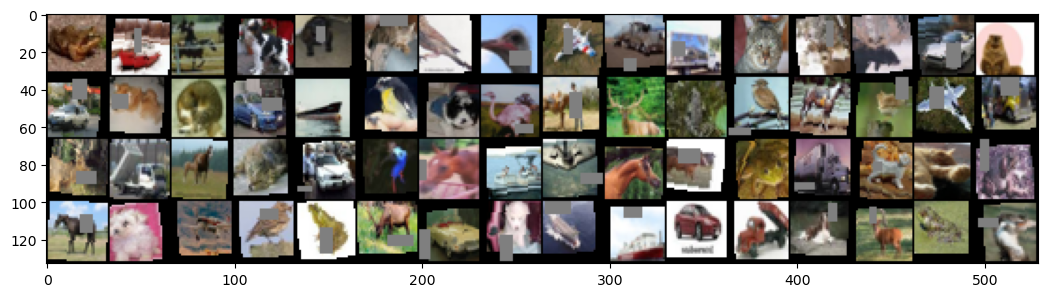

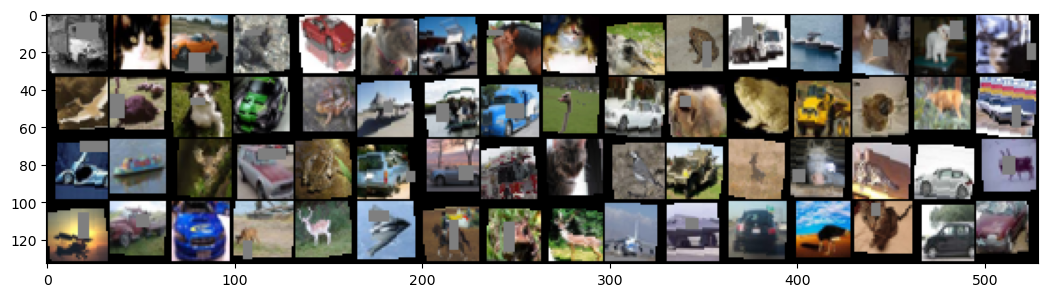

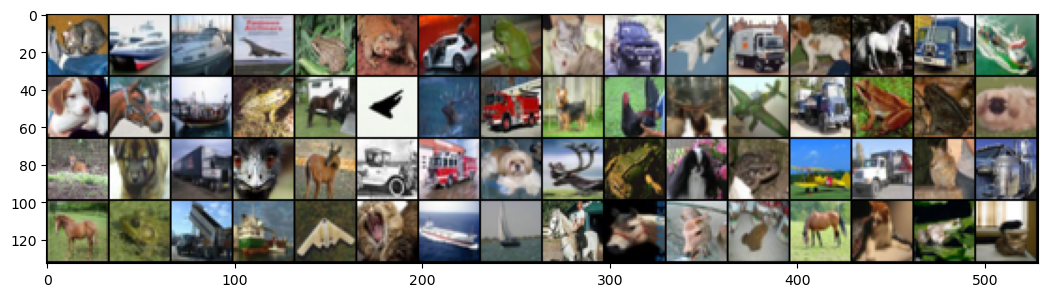

In [10]:
sample_show(train_dataset)
sample_show(valid_dataset)
sample_show(test_dataset)

## 2. モデル構築
---

### カスタムレイヤー

In [11]:
# Convolution層、BatchNormalization層(option)、ReLU層をまとめたブロック
# ブロックを作成することで、モデル定義のコードが煩雑になることを防ぐ
class EncoderBlock(nn.Module):
    def __init__(self, in_feature, out_future, use_bn=True):
        super().__init__()
        self.use_bn = use_bn

        self.in_feature = in_feature
        self.out_feature = out_future

        # BatchNormalizationを使用する場合、バイアス項は無くても良い
        # 標準化の際にバイアスもまとめて処理されるため
        self.conv = nn.Conv2d(in_feature, out_future, kernel_size=3, stride=1, padding=1, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_future)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out) if self.use_bn else x  # bn層を使わない場合はxを代入
        out = self.relu(out)
        return out

### モデル定義

In [12]:
class Classifier(nn.Module):
    def __init__(self, class_num, enc_dim, in_w, in_h,type=0):
        super().__init__()

        if(type == 0):
            # self.enc_dim = enc_dim
            self.in_w = in_w
            self.in_h = in_h
            self.fc_dim = enc_dim*4 * int(in_h/2/2/2) * int(in_w/2/2/2) #pooling回数分割る
            self.class_num = class_num

            self.encoder = nn.Sequential(
                EncoderBlock(3      , enc_dim),
                EncoderBlock(enc_dim, enc_dim),
                nn.MaxPool2d(kernel_size=2),#h,wが1/2

                EncoderBlock(enc_dim  , enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*2, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                nn.MaxPool2d(kernel_size=2),
            )


            self.fc = nn.Sequential(
                nn.Linear(self.fc_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, self.class_num),
            )
        elif(type == 10):
            self.in_w = in_w
            self.in_h = in_h
            self.fc_dim = enc_dim*4 * int(in_h/2/2/2) * int(in_w/2/2/2) #pooling回数分割る
            self.class_num = class_num

            self.encoder = nn.Sequential(
                EncoderBlock(3      , enc_dim),
                EncoderBlock(enc_dim, enc_dim),
                EncoderBlock(enc_dim, enc_dim),
                nn.MaxPool2d(kernel_size=2),#h,wが1/2

                EncoderBlock(enc_dim  , enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*2, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                nn.MaxPool2d(kernel_size=2),
            )


            self.fc = nn.Sequential(
                nn.Linear(self.fc_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, self.class_num),
            )
        elif(type == 1):
            self.in_w = in_w
            self.in_h = in_h
            self.fc_dim = enc_dim*8 * int(in_h/2/2/2) * int(in_w/2/2/2) #pooling回数分割る
            self.class_num = class_num

            self.encoder = nn.Sequential(
                EncoderBlock(3      , enc_dim),
                EncoderBlock(enc_dim, enc_dim),
                nn.MaxPool2d(kernel_size=2),#h,wが1/2

                EncoderBlock(enc_dim  , enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*2, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*4, enc_dim*8),
                EncoderBlock(enc_dim*8, enc_dim*8),
            )


            self.fc = nn.Sequential(
                nn.Linear(self.fc_dim,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, self.class_num),
            )
        
        elif(type == 2):
            self.in_w = in_w
            self.in_h = in_h
            self.fc_dim = enc_dim * int(in_h/2/2/2) * int(in_w/2/2/2) #pooling回数分割る
            self.class_num = class_num

            self.encoder = nn.Sequential(
                EncoderBlock(3      , enc_dim),
                EncoderBlock(enc_dim, enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                nn.MaxPool2d(kernel_size=2),#h,wが1/2

                EncoderBlock(enc_dim*2, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*8),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*8, enc_dim*8),
                EncoderBlock(enc_dim*8, enc_dim*4),
                EncoderBlock(enc_dim*4, enc_dim*4),
                nn.MaxPool2d(kernel_size=2),

                EncoderBlock(enc_dim*4, enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim*2),
                EncoderBlock(enc_dim*2, enc_dim),
            )


            self.fc = nn.Sequential(
                nn.Linear(self.fc_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, self.class_num),
            )
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(-1, self.fc_dim)

        out = self.fc(out)

        return out

### 重みの初期化
Pytorchは何も指定しない場合、一様分布を用いて重みの初期化を行うが、勾配消失を起こしにくい初期化方法が提案されている。  
 - kaimingの初期化(Heの初期化)：ReLU関数に有効
 - Xavierの初期化(Glorotの初期化)：Sigmoid関数に有効  

In [13]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d): # Convolution層が引数に渡された場合
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu') # kaimingの初期化
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)   # bias項は0に初期化
    elif isinstance(m, nn.BatchNorm2d):         # BatchNormalization層が引数に渡された場合
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):              # 全結合層が引数に渡された場合
        nn.init.kaiming_normal_(m.weight.data)  # kaimingの初期化
        nn.init.constant_(m.bias.data, 0)       # biasは0に初期化

### モデルの構築と確認

In [14]:
# モデルの構築
model = Classifier(class_num=10,in_w=32, in_h=32,**cfg.model)

# 計算に使用するデバイスへモデルを転送
model.to(device)

# 重みの初期化
model.apply(initialize_weights)

# model.applyは以下のコードと同じ動作をする
# for module in model.childlen():
#     initialize_weights(module)

# 構築したモデルの構造を確認
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 4, 4]            --
│    └─EncoderBlock: 2-1                 [10, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [10, 64, 32, 32]          1,728
│    │    └─BatchNorm2d: 3-2             [10, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [10, 64, 32, 32]          --
│    └─EncoderBlock: 2-2                 [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-4                  [10, 128, 32, 32]         73,728
│    │    └─BatchNorm2d: 3-5             [10, 128, 32, 32]         256
│    │    └─ReLU: 3-6                    [10, 128, 32, 32]         --
│    └─EncoderBlock: 2-3                 [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-7                  [10, 128, 32, 32]         147,456
│    │    └─BatchNorm2d: 3-8             [10, 128, 32, 32]         256


## 3. 学習
---

### 損失関数と最適化手法

In [15]:
# 誤差関数(損失関数)を指定
criterion = nn.CrossEntropyLoss()  # 交差エントロピー
print(criterion)

##optimizer関係
def make_optimizer(params, name, **kwargs):
    # Optimizer作成
    return optim.__dict__[name](params, **kwargs)

##--------------------
# 最適化アルゴリズムを指定
optimizer = make_optimizer(model.parameters(), **cfg.optimizer)  # 最適化関数Adam
print(optimizer)
 #　学習率調整スケジューラを作成
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min',patience=5,factor=0.1) 

CrossEntropyLoss()


TypeError: __init__() got an unexpected keyword argument 'momentum'

### 記録用のtensorboard作成

In [16]:
# now = datetime.now()
# cur_path = os.getcwd()
# #basename_without_ext = os.path.splitext(os.path.basename(__file__))[0] #pythonファイルの時ファイル名取得
# log_path = os.path.join(cur_path,"log","session2021_cnn-2","tuningname") #"このファイルのあるディレクトリ/log/fixseed/実行日時"以下にファイルを作成
# print(log_path)
# writer = SummaryWriter(log_dir=log_path)

### モデルの学習

In [17]:

# 学習過程を保存するためのリストを用意
history = {
    'train_loss': [],
    'train_acc' : [],
    'valid_loss': [],
    'valid_acc' : []
}

# エポックの数だけ繰り返す
for epoch in range(cfg.epochs):
    # プログレスバーの用意
    loop = tqdm(train_loader, unit='batch', desc='| Train | Epoch {:>3} |'.format(epoch+1))

    #========== 学習用データへの処理 ==========#
    # モデルを学習モードに設定
    model.train()

    #ミニバッチ＝イテレーションごとの
    batch_loss = []
    batch_acc  = []

    # ミニバッチ単位で繰り返す
    for batch in loop:
        x, label = batch
        x = x.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        # 学習のメイン処理
        optimizer.zero_grad()       # (1) パラメータの勾配を初期化
        out = model(x)              # (2) データをモデルに入力(順伝播)
        loss = criterion(out, label)    # (3) 誤差関数の値を算出
        loss.backward()             # (4) パラメータの勾配を算出(逆伝播)
        optimizer.step()            # (5) 勾配の情報からパラメータを更新

        # 正答率(accuracy)を算出
        pred_class = torch.argmax(out, dim=1)        # モデルの出力から予測ラベルを算出
        acc = torch.sum(pred_class == label)/len(label) # 予測ラベルと正解ラベルが一致すれば正解

        # 1バッチ分の誤差と正答率をリストに保存
        batch_loss.append(loss)
        batch_acc.append(acc)

    # バッチ単位の結果を平均し、1エポック分の誤差を算出
    train_avg_loss = torch.tensor(batch_loss).mean()
    train_avg_acc  = torch.tensor(batch_acc).mean()
    
    #========== 検証用データへの処理 ==========#
    # モデルを評価モードに設定
    model.eval()
    batch_loss = []
    batch_acc = []

    # 勾配計算に必要な情報を記録しないよう設定
    with torch.no_grad():
        # ミニバッチ単位で繰り返す
        for batch in valid_loader:
            x, label = batch
            x = x.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)

            # 順伝播と誤差の計算のみ行う
            out = model(x)
            loss = criterion(out, label)

            # 正答率(accuracy)を算出
            pred_class = torch.argmax(out, dim=1)
            acc = torch.sum(pred_class == label)/len(label)

            # 1バッチ分の誤差をリストに保存
            batch_loss.append(loss)
            batch_acc.append(acc)

        # バッチ単位の結果を平均し、1エポック分の誤差を算出
        valid_avg_loss = torch.tensor(batch_loss).mean()
        valid_avg_acc  = torch.tensor(batch_acc).mean()
        scheduler.step(valid_avg_loss)
        now_lr = optimizer.param_groups[0]["lr"]

    # 学習過程を記録
    history['train_loss'].append(train_avg_loss)
    history['valid_loss'].append(valid_avg_loss)
    history['train_acc'].append(train_avg_acc)
    history['valid_acc'].append(valid_avg_acc)

    #学習過程をtensorboardに記録
    # writer.add_scalars(f'{tuningName}/loss', {'train_loss':train_avg_loss, 'valid_loss':valid_avg_loss}, epoch)
    # writer.add_scalars(f'{tuningName}/acc', {'train_acc':train_avg_acc, 'valid_acc':valid_avg_acc}, epoch) 
        #学習過程をmlflowに記録
    #log_metric_stepは連続的に変化する値を保存
    writer.log_metric_step('train_loss', train_avg_loss,epoch+1) #引数：評価指標の名前,値,step
    writer.log_metric_step('train_acc', train_avg_acc,epoch+1)
    writer.log_metric_step('valid_loss', valid_avg_loss,epoch+1)
    writer.log_metric_step('valid_acc', valid_avg_acc,epoch+1)
    
    print(f"| Train | Epoch   {epoch+1} |: train_loss:{train_avg_loss:.3f}, train_acc:{train_avg_acc*100:3.3f}% | valid_loss:{valid_avg_loss:.5f}, valid_acc:{valid_avg_acc*100:3.3f}%, | now_lr:{now_lr:.1E}%")

print('Finished Training')
writer.set_terminated()#一つのexperimentまたはrunを終えるときは必ず呼び出す


| Train | Epoch   1 |: 100%|██████████| 175/175 [00:47<00:00,  3.70batch/s]


| Train | Epoch   1 |: train_loss:2.475, train_acc:12.138% | valid_loss:2.23470, valid_acc:16.957%, | now_lr:1.0E-02%


| Train | Epoch   2 |:  89%|████████▉ | 156/175 [00:43<00:05,  3.58batch/s]


KeyboardInterrupt: 

### 学習曲線

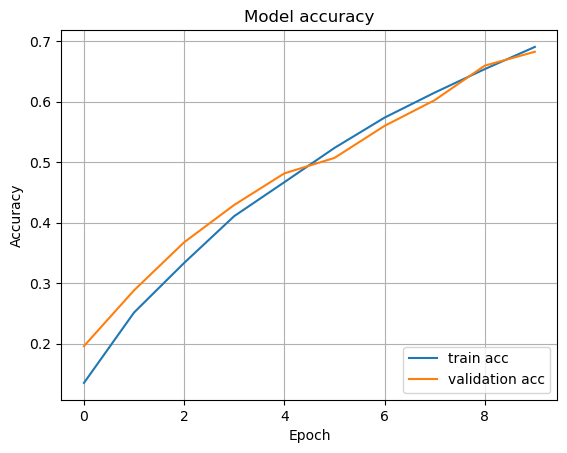

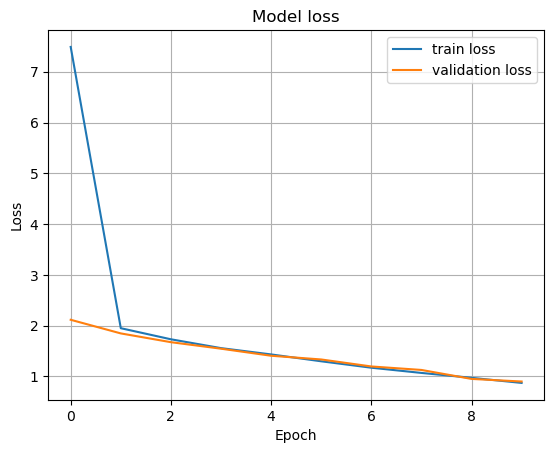

In [ ]:
# Accuracyを描画
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train acc', 'validation acc'], loc='lower right')
plt.grid(True)
plt.show()

# Lossを描画
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.grid(True)
plt.show()

### 重みの保存

In [ ]:
# 重みの保存
dir = './'
# torch.save(model.state_dict(), dir + 'ex5_weights.pth')

# 重みの読込
# model = model().to(device)                                    # 保存時と全く同じ構成のモデルを構築
# params = torch.load(dir + 'ex5_weights.pth', map_location=device)   # 保存した重みを読み出す
# model.load_state_dict(params)                                       # 重みをモデルに反映

## 4. モデルの検証(Test)
---

In [ ]:
test_loader = fix_seed_dataLoader(
    test_dataset,
    #batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    **cfg.dataloader
)
print(f"test : {len(test_dataset):5.0f} [set]")

test : 10000 [set]


In [ ]:
# モデルを評価モードに設定
model.eval()
batch_loss = []
batch_acc = []

# 勾配計算に必要な情報を記録しないよう設定
with torch.no_grad():
    loop = tqdm(test_loader, unit='batch', desc='| Test | Epoch {:>3} |'.format(epoch+1))

    # ミニバッチ単位で繰り返す
    for batch in loop:
        x, label = batch
        x = x.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        # 順伝播のみ行う
        out = model(x)
        batch_loss = criterion(out, label)

        # 正答率(accuracy)を算出
        pred_class = torch.argmax(out, dim=1)
        acc = torch.sum(pred_class == label)/len(label)

        # 1バッチ分のaccをリストに保存
        batch_acc.append(acc)

    # バッチ単位の結果を平均し、1エポック分の誤差を算出
    test_avg_loss = torch.tensor(batch_loss).mean().item()
    test_avg_acc  = torch.tensor(batch_acc).mean().item()

print("テストデータに対する結果")
test_loss_str = f"test_loss   ：{test_avg_loss:3.5f}"
print(test_loss_str)
test_acc_str = f"test_acc    ：{test_avg_acc*100:2.3f}%"
print(test_acc_str)

# writer.add_text(f"{tuningName}/test_loss",str(test_avg_loss),0)
# writer.add_text(f"{tuningName}/test_acc",str(test_avg_acc),1)
# writer.log_metric('test_loss', test_avg_loss) #引数：　評価指標の名前,値
# writer.log_metric('test_acc', test_avg_acc)


writer.set_terminated()#一つのexperimentまたはrunを終えるときは必ず呼び出す

| Test | Epoch   3 |: 100%|██████████| 40/40 [00:00<00:00, 44.05batch/s]

テストデータに対する結果
test_loss   ：1.54014
test_acc    ：39.385%



/tmp/ipykernel_3112/993963945.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_avg_loss = torch.tensor(batch_loss).mean().item()


## おまけ

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        #print(predicted.size())
        
        c = (predicted == labels).squeeze()
        #print(c.size())
        for i in range(len(labels)): #ミニバッチの先頭からいくつのバッチを見るか
            label = labels[i]
            class_correct[label] += c[i].item() #Trueなら+=1 Falseなら0
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 34 %
Accuracy of   car : 54 %
Accuracy of  bird : 12 %
Accuracy of   cat : 10 %
Accuracy of  deer : 30 %
Accuracy of   dog : 27 %
Accuracy of  frog : 60 %
Accuracy of horse : 55 %
Accuracy of  ship : 67 %
Accuracy of truck : 40 %


In [ ]:
!nvidia-smi

Wed Dec 14 14:19:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.46       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 55%   46C    P0   137W / 350W |   6291MiB / 24576MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------